<a href="https://colab.research.google.com/github/Swarno-Coder/ObjectLocalization-PyTorch/blob/master/Object_Localization_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

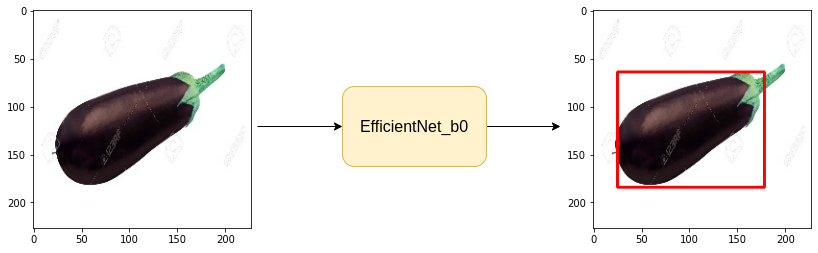

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-c9y511fz
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-c9y511fz
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 30.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

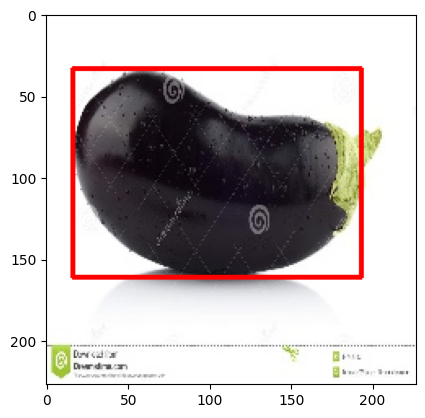

In [7]:
row = df.iloc[118]

img = cv2.imread('/content/object-localization-dataset/'+row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bbox_img = cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), (255,0,0), 2)
plt.imshow(img)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [11]:
class ObjectLocalization(torch.utils.data.Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augs = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin, ymin = row.xmin, row.ymin
    xmax, ymax = row.xmax, row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augs:
      data = self.augs(image=img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    bbox = torch.Tensor(bbox)

    return img, bbox

In [12]:
trainset = ObjectLocalization(train_df, train_augs)
validset = ObjectLocalization(valid_df, valid_augs)

In [13]:
print(f'tot Train:{len(trainset)}\n tot Val:{len(validset)}')

tot Train:148
 tot Val:38


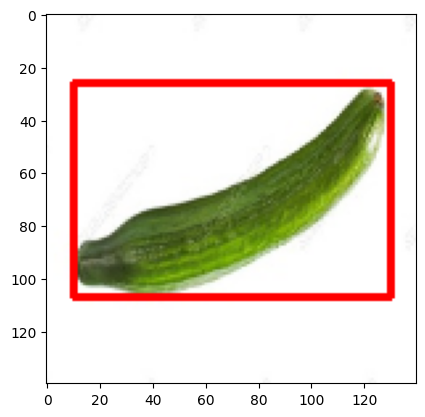

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, BATCH_SIZE)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [27]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

  def forward(self, images, gt_box=None):

    logits = self.backbone(images)

    if gt_box != None:
      loss = nn.MSELoss()(logits, gt_box)
      return logits, loss
    return logits


In [28]:
model = ObjLocModel()

In [29]:
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [22]:
#checking
model(torch.rand(1, 3, 140, 140).to(DEVICE)).shape


torch.Size([1, 4])

# Create Train and Eval Function

In [33]:
def train_fn(model, dataloader, optim):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    img, gt_box = data
    img, gt_box = img.to(DEVICE), gt_box.to(DEVICE)

    bboxes, loss = model(img, gt_box)

    optim.zero_grad()
    loss.backward()
    optim.step()

    total_loss += loss.item()
  return (total_loss / len(dataloader))

In [34]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):
      img, gt_box = data
      img, gt_box = img.to(DEVICE), gt_box.to(DEVICE)

      bboxes, loss = model(img, gt_box)

      total_loss += loss.item()
  return (total_loss / len(dataloader))

#Training Loop

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS-SAVED")
    best_val_loss = valid_loss

  print(f"Epoch: {i+1} train_loss:{train_loss} valid_loss:{valid_loss}")

#Inference

In [31]:
import utils

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  img, gt_bbx = validset[1]

  img = img.unsqueeze(0).to(DEVICE)
  out_bbox = model(img)

  utils.compare_plots(img, gt_bbx, out_bbox)


# For updates about upcoming and current guided projects follow me on...

Twitter : [@SwarnodipN](https://twitter.com/SwarnodipN
)

Linkedin : www.linkedin.com/in/swarnodip--nag